# Pergunta Problema

- Em caso de criptomoedas onde existe pode existir volatilidade nos dados, qual seria o modelo que melhor se adaptaria ?

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import itertools
import matplotlib.dates as mdates
import seaborn as sns
import os
!pip install ta
import ta
import datetime

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=46075980c9552f95e5770991b8d564dd2b7854700ca3504fe3e3e2dcd5d6ff43
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
def encontrar_pasta_mais_recente(caminho_base):
    """
    Encontra a pasta mais recente com a mascara 'data=' em um determinado caminho.

    Argumento:
        caminho_base (str): O caminho base onde as pastas estão localizadas.

    Retorno:
        str: O caminho completo para a pasta mais recente, ou None se nenhuma pasta for encontrada.
    """

    pastas_data = []
    for nome_pasta in os.listdir(caminho_base):
        if nome_pasta.startswith("date="):
            try:
                data_str = nome_pasta.split("=")[1]
                data_obj = datetime.datetime.strptime(data_str, "%Y%m%d")
                pastas_data.append((data_obj, os.path.join(caminho_base, nome_pasta)))
            # Ignora pastas com formatos de data invalidos
            except ValueError:
                pass
    # Nenhuma pasta encontrada
    if not pastas_data:
        return None

    pasta_mais_recente = max(pastas_data)[1]
    return pasta_mais_recente

In [ ]:
caminho_base = "/content/drive/MyDrive/Colab Notebooks/FIAP_POS_ML/FASE3/"
pasta_mais_recente = encontrar_pasta_mais_recente(caminho_base)

if pasta_mais_recente:
    print(f"A pasta mais recente eh: {pasta_mais_recente}")
else:
    print("Nenhuma pasta encontrada com a mascara 'date='.")

A pasta mais recente eh: /content/drive/MyDrive/Colab Notebooks/FIAP_POS_ML/FASE3/date=20240306


In [ ]:
df = pd.read_parquet(pasta_mais_recente)
df.head()

,timestamp,price,date
0,1709683200000,64291.536558,2024-03-06
1,1709769600000,66145.919279,2024-03-07
2,1709856000000,66944.876391,2024-03-08
3,1709942400000,68315.251921,2024-03-09
4,1710028800000,68508.003963,2024-03-10


In [ ]:
df.drop(columns=['timestamp'], inplace=True)

# 1. Preparação dos Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   price   366 non-null    float64       
 1   date    366 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


## 1.1 Verificação de Dados Faltantes e Duplicados

Embora o Non-Null Count do `df.info()` indique que não há valores nulos, vamos confirmar.

In [ ]:
df.isnull().sum()

,0
price,0
date,0


In [ ]:
def duplicates_count(df):
    """
    Verifica se existem valores duplicados no Dataframe e retorna a quantidade de duplicados.

    Argumento:
        df (pd.DataFrame): O Dataframe a ser verificado.

    Retorno:
        int: A quantidade de duplicados no Dataframe.
    """
    duplicates = df[df.duplicated(keep=False)]

    if not duplicates.empty:
        print("Valores duplicados encontrados:")
        print(duplicates)
    else:
        print("Nenhum valor duplicado encontrado.")

duplicates_count(df)

Nenhum valor duplicado encontrado.


## 1.2 Ordenação

Vamos nos certificar que os dados estejam ordenados pela coluna 'date'.

In [ ]:
df_sorted = df.sort_values('date', ascending=True)

## 1.3 Frequência dos Dados

In [ ]:
def validando_frequencia(df):
  """
  Valida a frequência dos dados no DataFrame.

  Argumento:
      df (pd.DataFrame): O DataFrame a ser validado.

  Retorno:
      pd.Series: Uma serie contendo a contagem de ocorrencias para cada frequencia de data.

  Exemplo:
        Se a maior parte dos valores for 1: Dados diários
        Se a maior parte dos valores for 7: Dados semanais
        Se houver uma mistura de valores, será necessário investigar mais detalhadamente.
  """
  date_diffs = df_sorted['date'].diff().dt.days
  return date_diffs.value_counts()

validando_frequencia(df_sorted)

,count
date,
1.0,364
0.0,1


In [ ]:
# Filtrando para encontrar onde a diferença entre as datas é 0
date_diffs = df_sorted['date'].diff().dt.days
dados_com_0_diff = df_sorted[date_diffs == 0]
print(dados_com_0_diff)

            price                date
365  89795.518572 2025-03-05 19:18:04


 As observações com diferenças de 0 dias podem afetar o desempenho e a precisão de um modelo de série temporal. Isso ocorre porque esses valores podem ser interpretados como dados duplicados ou fora do padrão, o que pode levar a ruídos ou padrões artificiais no modelo. Para esta análise seria interessante que os dados sigam uma sequência temporal consistente, sem duplicações ou falhas nos intervalos de tempo.

### Como as diferenças de 0 dias podem impactar:

1. **Modelos de Séries Temporais Sensíveis ao Tempo**: Modelos como ARIMA, SARIMA, LSTM, entre outros, assumem que as observações seguem um padrão temporal regular. Se houver duplicatas de data (diferença de 0 dias), o modelo pode não conseguir aprender corretamente as dependências temporais entre os pontos de dados, resultando em previsões imprecisas.

2. **Extrapolação de Padrões**: Se o modelo encontrar registros com intervalos de 0 dias, ele pode interpretar erroneamente que existe um padrão ou uma tendência de "reinício" a cada intervalo, distorcendo os resultados.

3. **Falta de Generalização**: Modelos que têm dados com registros duplicados ou com intervalo de 0 dias podem acabar "overfitting" no conjunto de dados (ajustando-se excessivamente aos dados presentes, sem capturar corretamente as tendências do mundo real).

### Como corrigir esse problema:

1. **Remover Duplicatas**: Você pode remover registros com diferenças de 0 dias para garantir que cada data seja única no seu conjunto de dados.
   
2. **Agregação de Dados**: Se o problema for causado por múltiplos registros no mesmo dia, uma estratégia comum é **agregar os dados** por dia (por exemplo, calculando a média, soma ou mediana dos valores de `price` para o mesmo dia).

3. **Interpolação de Dados Faltantes**: Se os dados faltantes (ou com diferença de 0 dias) forem um problema, uma alternativa é interpolar esses valores para preencher lacunas, embora isso deva ser feito com cuidado.


### **Agrupar os Dados para o Mesmo Dia**:

Caso você tenha múltiplos registros no mesmo dia, pode agregá-los (como média, soma, ou outro critério) para que o modelo tenha uma observação única por dia:

In [ ]:
# Convertendo a coluna 'date' para datetime no formato 'YYYY-MM-DD'
df_sorted['date'] = pd.to_datetime(df_sorted['date']).dt.strftime('%Y-%m-%d')
# Agrupando os dados por data, calculando a média do preço
df_agrupado = df_sorted.groupby('date').agg({'price': 'mean'}).reset_index()

In [ ]:
df_agrupado.tail()

,date,price
360,2025-03-01,84441.901224
361,2025-03-02,86005.256297
362,2025-03-03,94261.532865
363,2025-03-04,86124.714187
364,2025-03-05,88553.161942


## 1.4 Definição do Índice

Defina a coluna 'date' como o índice do DataFrame para facilitar a análise de séries temporais, pois o Pandas entende automaticamente que esse índice é temporal, facilitando a manipulação de séries temporais.

In [ ]:
df_agrupado = df_agrupado.set_index('date')
df_agrupado

,price
date,
2024-03-06,64291.536558
2024-03-07,66145.919279
2024-03-08,66944.876391
2024-03-09,68315.251921
2024-03-10,68508.003963
...,...
2025-03-01,84441.901224
2025-03-02,86005.256297
2025-03-03,94261.532865


# 2. Análise Exploratória de Dados (EDA)

In [ ]:
df_agrupado.describe()

,price
count,365.000000
mean,74621.832870
std,15690.574192
min,53923.356111
25%,62966.529319
50%,67740.016902
75%,93663.447520
max,106182.236820


In [ ]:
df_agrupado

,price
date,
2024-03-06,64291.536558
2024-03-07,66145.919279
2024-03-08,66944.876391
2024-03-09,68315.251921
2024-03-10,68508.003963
...,...
2025-03-01,84441.901224
2025-03-02,86005.256297
2025-03-03,94261.532865


## Visualização da Série Temporal

vamos Plotar a série temporal para identificar tendências, sazonalidades e padrões. Vamos também usar gráficos de linha para visualizar a evolução do preço ao longo do tempo.

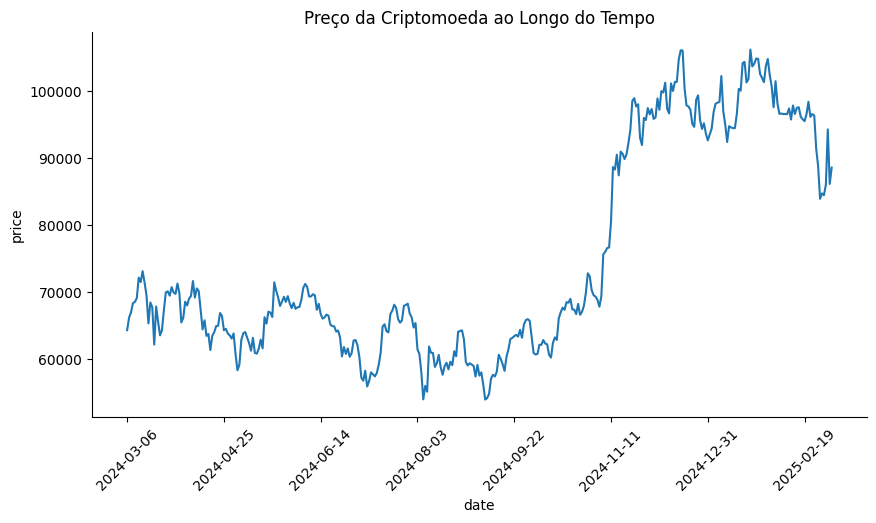

In [ ]:
df_agrupado['price'].plot(kind='line', figsize=(10, 5), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('price')
plt.title('Preço da Criptomoeda ao Longo do Tempo')
plt.show()

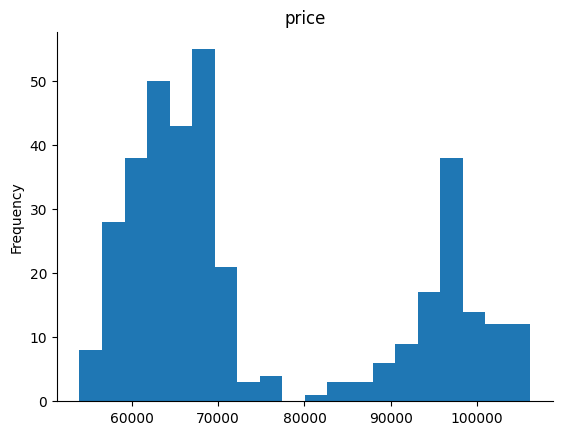

In [ ]:
df_agrupado['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Análise de Sazonalidade

Realizamos a decomposição de séries temporais para identificar componentes de tendência, sazonalidade e resíduos.

A sazonalidade refere-se a padrões repetitivos e previsíveis que ocorrem em uma série temporal em intervalos regulares. Esses padrões podem ser diários, semanais, mensais, anuais ou de qualquer outra periodicidade.

Em outras palavras, a sazonalidade é quando os dados exibem um comportamento cíclico que se repete ao longo do tempo.

**Nossos dados são diários, então não encontraremos sazonalidades semanais ou anuais.**

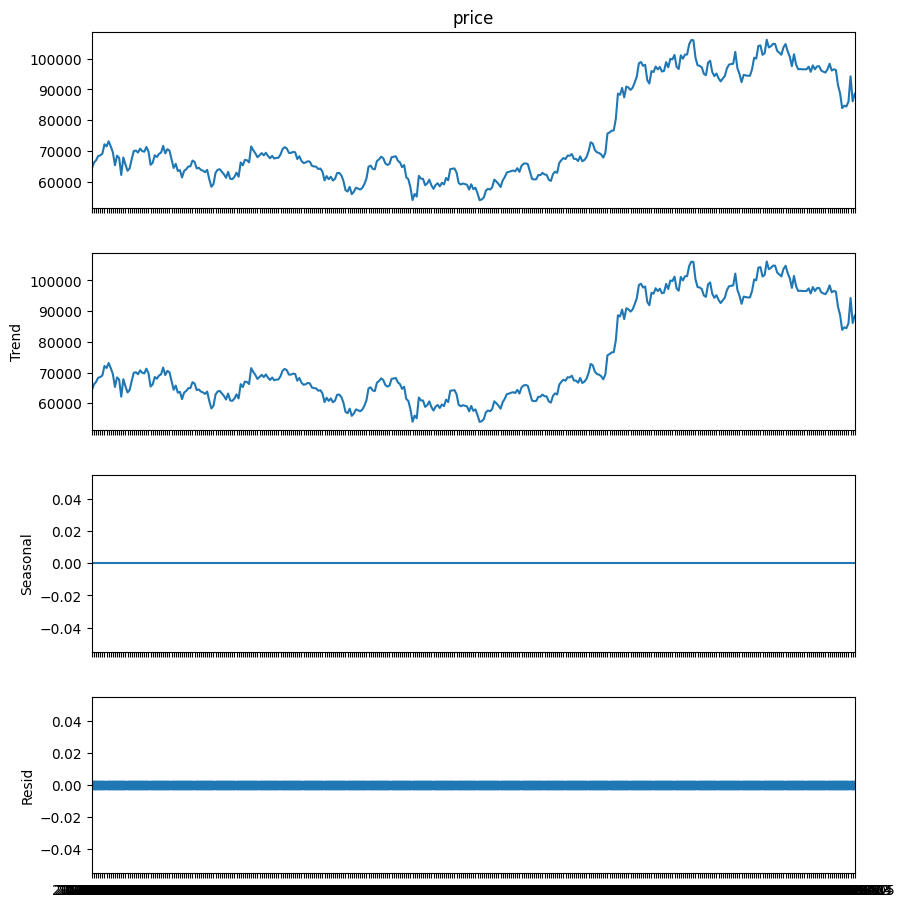

In [ ]:
decomposition = seasonal_decompose(df_agrupado['price'], model='additive', period = 1) # use period = 7 para sazonalidade semanal.
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

A volatilidade (desvio padrão dos retornos) para entender a variação dos preços.

A volatilidade mede o grau de variação ou flutuação dos preços de um ativo financeiro em um determinado período.

Em termos simples, a volatilidade indica o quão "instável" é o preço de um ativo.

No mercado financeiro, a volatilidade é frequentemente medida pelo desvio padrão dos retornos de um ativo.


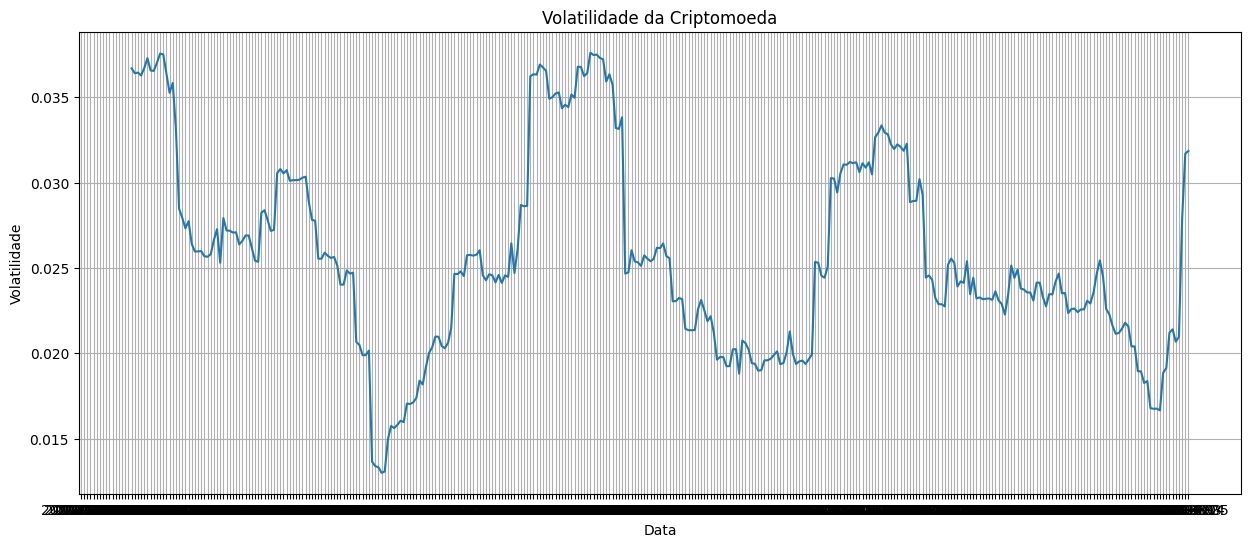

In [ ]:
df_analise = pd.DataFrame(df_agrupado['price'])

df_analise['returns'] = df_agrupado['price'].pct_change()
df_analise['volatility'] = df_analise['returns'].rolling(window=30).std() # volatilidade calculada com janela de 30 dias.
plt.figure(figsize=(15, 6))
plt.plot(df_analise['volatility'])
plt.title('Volatilidade da Criptomoeda')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.grid(True)
plt.show()

Podemos verificar uma Volatilidade dos Considerável dos Dados, aqui temos uma ideia de que o modelo de LSMT pode ter um desempenho melhor que o ARIMA.

In [ ]:
df_analise['lag_1'] = df_agrupado['price'].shift(1)
df_analise['rolling_mean_3'] = df_agrupado['price'].rolling(window=3).mean()
df_analise['rolling_mean_7'] = df_agrupado['price'].rolling(window=7).mean()
df_analise['rolling_mean_30'] = df_agrupado['price'].rolling(window=30).mean()
df_analise['rolling_mean_45'] = df_agrupado['price'].rolling(window=45).mean()
df_analise['rolling_mean_60'] = df_agrupado['price'].rolling(window=60).mean()
df_analise['rolling_mean_75'] = df_agrupado['price'].rolling(window=75).mean()
df_analise['rolling_mean_90'] = df_agrupado['price'].rolling(window=90).mean()

In [ ]:
df_analise.tail()

,price,returns,volatility,lag_1,rolling_mean_3,rolling_mean_7,rolling_mean_30,rolling_mean_45,rolling_mean_60,rolling_mean_75,rolling_mean_90
date,,,,,,,,,,,
2025-03-01,84441.901224,-0.003155,0.020681,84709.144778,84350.386989,89442.187772,95835.439684,98223.420061,97680.993590,97671.137161,97935.051270
2025-03-02,86005.256297,0.018514,0.020966,84441.901224,85052.100766,87933.773794,95209.564444,97905.466814,97555.950216,97403.552482,97809.424038
2025-03-03,94261.532865,0.095997,0.027840,86005.256297,88236.230129,87638.640905,94938.869070,97776.954672,97553.906162,97246.574075,97791.961778
2025-03-04,86124.714187,-0.086322,0.031708,94261.532865,88797.167783,86885.490522,94453.866622,97376.155130,97375.115618,97056.829248,97681.884925
2025-03-05,88553.161942,0.028197,0.031861,86124.714187,89646.469665,86856.546608,94153.361469,97025.456156,97216.262604,96932.853357,97567.125953


## Interpretação dos Indicadores:

### Médias Móveis (MA):

O cruzamento das médias móveis de curto e longo prazo pode indicar sinais de compra ou venda.
Quando a MA de curto prazo cruza acima da MA de longo prazo, pode ser um sinal de compra.
Quando a MA de curto prazo cruza abaixo da MA de longo prazo, pode ser um sinal de venda.

### Índice de Força Relativa (RSI):

Valores acima de 70 indicam condições de sobrecompra, sugerindo uma possível reversão de baixa.
Valores abaixo de 30 indicam condições de sobrevenda, sugerindo uma possível reversão de alta.

### Convergência/Divergência da Média Móvel (MACD):

O cruzamento da linha MACD com a linha de sinal pode indicar sinais de compra ou venda.
Quando a linha MACD cruza acima da linha de sinal, pode ser um sinal de compra.
Quando a linha MACD cruza abaixo da linha de sinal, pode ser um sinal de venda.
O histograma MACD indica a diferença entre a linha MACD e a linha de sinal, fornecendo informações adicionais sobre a força da tendência.

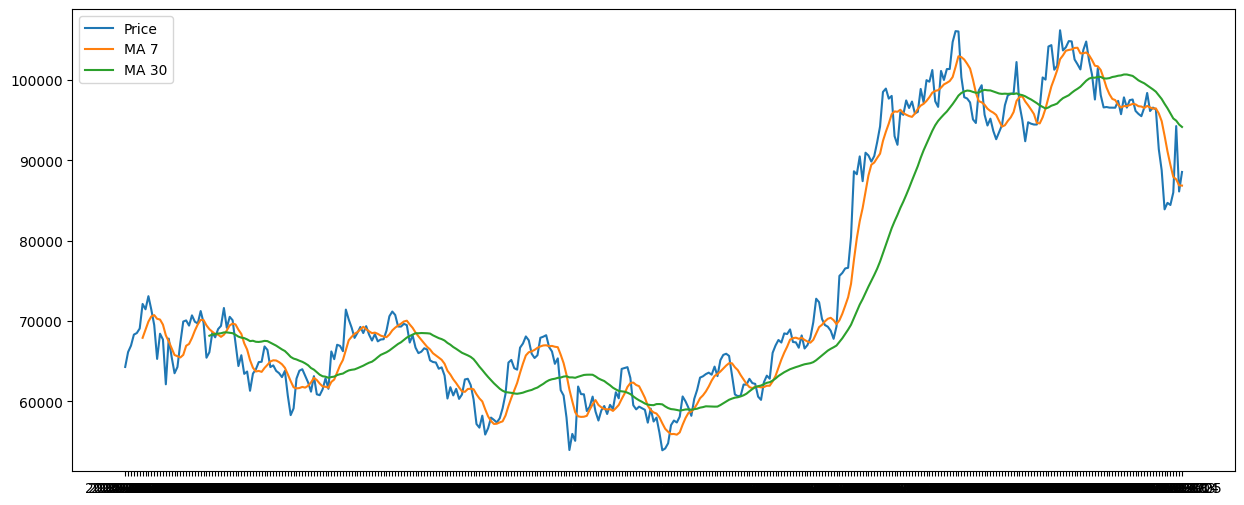

In [ ]:
# Calculate Simple Moving Average (SMA)
df_analise['MA_7'] = ta.trend.sma_indicator(df_analise['price'], window=7)
df_analise['MA_30'] = ta.trend.sma_indicator(df_analise['price'], window=30)

# Calculate RSI
df_analise['RSI'] = ta.momentum.rsi(df_analise['price'], window=14)

# Calculate MACD
macd = ta.trend.MACD(df_analise['price'])
df_analise['MACD'] = macd.macd()
df_analise['MACD_signal'] = macd.macd_signal()
df_analise['MACD_hist'] = macd.macd_diff()

plt.figure(figsize=(15,6))
plt.plot(df_analise['price'], label = "Price")
plt.plot(df_analise['MA_7'], label = "MA 7")
plt.plot(df_analise['MA_30'], label = "MA 30")
plt.legend()
plt.show()

In [ ]:
df_analise.tail(14)

,price,returns,volatility,lag_1,rolling_mean_3,rolling_mean_7,rolling_mean_30,rolling_mean_45,rolling_mean_60,rolling_mean_75,rolling_mean_90,MA_7,MA_30,RSI,MACD,MACD_signal,MACD_hist
date,,,,,,,,,,,,,,,,,
2025-02-20,96554.871563,0.011089,0.018375,95495.891533,95942.306778,96513.766567,99584.860960,99128.777234,98325.171500,98777.420419,98430.093548,96513.766567,99584.860960,45.530301,-1031.728084,-908.907820,-122.820264
2025-02-21,98384.317382,0.018947,0.016783,96554.871563,96811.693493,96774.145622,99324.930312,99043.331075,98380.005558,98758.786917,98424.058242,96774.145622,99324.930312,51.282988,-834.309714,-893.988199,59.678484
2025-02-22,96135.155413,-0.022861,0.016750,98384.317382,97024.781453,96580.813326,99073.650989,99025.176776,98404.842967,98690.784033,98406.899260,96580.813326,99073.650989,44.991771,-849.549727,-885.100504,35.550777
2025-02-23,96564.154143,0.004462,0.016759,96135.155413,97027.875646,96437.127961,98823.535797,99059.564325,98369.316969,98680.253462,98390.768355,96437.127961,98823.535797,46.343846,-817.586309,-871.597665,54.011356
2025-02-24,96327.463091,-0.002451,0.016658,96564.154143,96342.257549,96462.572909,98539.944815,99147.368488,98319.025451,98675.956777,98427.687935,96462.572909,98539.944815,45.676764,-802.107860,-857.699704,55.591845
2025-02-25,91396.766869,-0.051187,0.018854,96327.463091,94762.794701,95836.945714,98093.302352,99073.149380,98247.666358,98546.265427,98421.742780,95836.945714,98093.302352,34.527171,-1174.171931,-920.994150,-253.177782
2025-02-26,88755.769336,-0.028896,0.019134,91396.766869,92159.999765,94874.071114,97633.419705,98944.176439,98154.730059,98396.331573,98341.460433,94874.071114,97633.419705,30.265706,-1662.972110,-1069.389742,-593.582369
2025-02-27,83900.114965,-0.054708,0.021209,88755.769336,88017.550390,93066.248743,97031.474552,98709.628529,97966.654985,98163.636710,98210.777311,93066.248743,97031.474552,24.321952,-2414.329613,-1338.377716,-1075.951897
2025-02-28,84709.144778,0.009643,0.021407,83900.114965,85788.343026,91112.652657,96478.008957,98493.023983,97817.416606,97941.531832,98069.176172,91112.652657,96478.008957,26.897924,-2910.948302,-1652.891833,-1258.056469


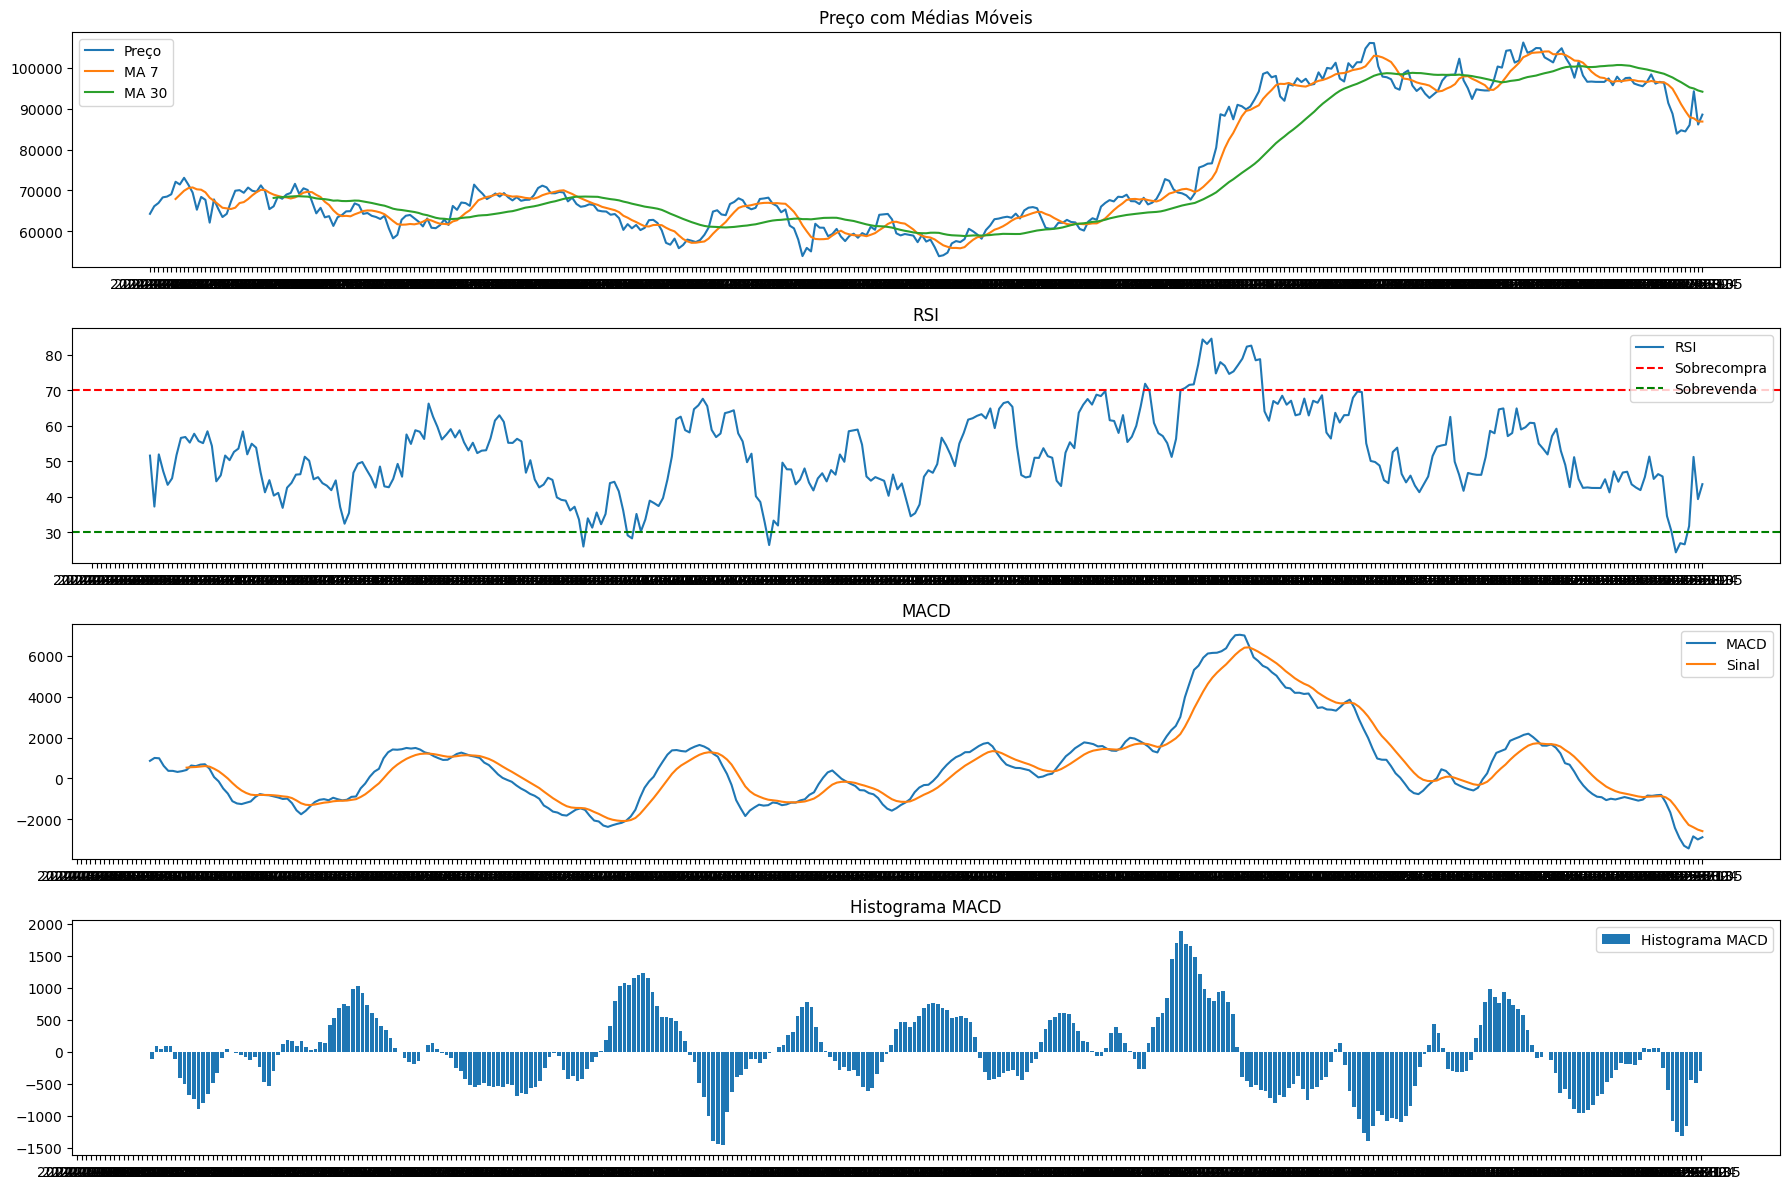

In [ ]:
plt.figure(figsize=(18, 12))

# Preço e Médias Móveis
plt.subplot(4, 1, 1)
plt.plot(df_analise['price'], label='Preço')
plt.plot(df_analise['MA_7'], label='MA 7')
plt.plot(df_analise['MA_30'], label='MA 30')
plt.title('Preço com Médias Móveis')
plt.legend()

# RSI
plt.subplot(4, 1, 2)
plt.plot(df_analise['RSI'], label='RSI')
plt.title('RSI')
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra')
plt.axhline(30, color='green', linestyle='--', label='Sobrevenda')
plt.legend()

# MACD
plt.subplot(4, 1, 3)
plt.plot(df_analise['MACD'], label='MACD')
plt.plot(df_analise['MACD_signal'], label='Sinal')
plt.title('MACD')
plt.legend()

# Histograma MACD
plt.subplot(4, 1, 4)
plt.bar(df_analise.index, df_analise['MACD_hist'], label='Histograma MACD')
plt.title('Histograma MACD')
plt.legend()

plt.tight_layout()
plt.show()

# Modelos de Séries Temporais

ARIMA (AutoRegressive Integrated Moving Average): Adequado para séries temporais estacionárias.

LSTM (Long Short-Term Memory): Uma rede neural recorrente poderosa para capturar dependências temporais complexas.

Prophet: Modelo desenvolvido pelo facebook, para previsão de séries temporais com forte sazonalidade.

In [ ]:
df_agrupado_2 = df_agrupado.copy()

In [ ]:
# Preparação dos dados para LSTM
def criar_dataset_lstm(dataset, tempo_passado=1):
  """
  Prepara os dados para LSTM.
  """
  dataX, dataY = [], []
  for i in range(len(dataset) - tempo_passado - 1):
      a = dataset[i:(i + tempo_passado), 0]
      dataX.append(a)
      dataY.append(dataset[i + tempo_passado, 0])
  return np.array(dataX), np.array(dataY)

def avaliar_modelos(df, coluna_preco='price', tamanho_teste=0.2):
    """
    Avalia o desempenho dos modelos ARIMA, LSTM e Prophet em uma série temporal.

    Args:
        df (pd.DataFrame): DataFrame com a série temporal.
        coluna_preco (str): Nome da coluna com os preços.
        tamanho_teste (float): Proporção dos dados para o conjunto de teste.

    Returns:
        pd.DataFrame: DataFrame com os resultados dos modelos.
    """

    # Divisão dos dados em treino e teste
    tamanho_treino = int(len(df) * (1 - tamanho_teste))
    treino, teste = df[coluna_preco][:tamanho_treino], df[coluna_preco][tamanho_treino:]

    resultados = {}

    # 2. Modelo ARIMA
    try:
        modelo_arima = ARIMA(treino, order=(5, 1, 0))  # Ajuste os parâmetros (p, d, q) conforme necessário
        modelo_arima_fit = modelo_arima.fit()
        previsoes_arima = modelo_arima_fit.forecast(steps=len(teste))
        rmse_arima = np.sqrt(mean_squared_error(teste, previsoes_arima))
        resultados['ARIMA'] = rmse_arima
    except Exception as e:
        print(f"Erro no ARIMA: {e}")

    # 3. Modelo LSTM
    try:
        dados_treino_lstm = treino.values.reshape(-1, 1)
        dados_teste_lstm = teste.values.reshape(-1, 1)

        tempo_passado = 60  # Ajuste o tempo passado conforme necessário
        X_treino, y_treino = criar_dataset_lstm(dados_treino_lstm, tempo_passado)
        X_teste, y_teste = criar_dataset_lstm(dados_teste_lstm, tempo_passado)

        X_treino = np.reshape(X_treino, (X_treino.shape[0], 1, X_treino.shape[1]))
        X_teste = np.reshape(X_teste, (X_teste.shape[0], 1, X_teste.shape[1]))

        # Modelo LSTM
        modelo_lstm = Sequential()
        modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(1, tempo_passado)))
        modelo_lstm.add(LSTM(50))
        modelo_lstm.add(Dense(1))
        modelo_lstm.compile(loss='mean_squared_error', optimizer='adam')
        modelo_lstm.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=0)

        previsoes_lstm = modelo_lstm.predict(X_teste)
        rmse_lstm = np.sqrt(mean_squared_error(y_teste, previsoes_lstm))
        resultados['LSTM'] = rmse_lstm
    except Exception as e:
        print(f"Erro no LSTM: {e}")

    # 4. Modelo Prophet
    try:
        df_prophet = df.reset_index()
        df_prophet = df_prophet[['date', coluna_preco]].rename(columns={'date': 'ds', coluna_preco: 'y'})

        modelo_prophet = Prophet()
        modelo_prophet.fit(df_prophet[:tamanho_treino])
        futuro = modelo_prophet.make_future_dataframe(periods=len(teste))
        previsoes_prophet = modelo_prophet.predict(futuro)
        rmse_prophet = np.sqrt(mean_squared_error(teste, previsoes_prophet['yhat'][tamanho_treino:]))
        resultados['Prophet'] = rmse_prophet
    except Exception as e:
        print(f"Erro no Prophet: {e}")

    return pd.Series(resultados)

In [ ]:
resultados_modelos = avaliar_modelos(df_agrupado)
print("\n\nRMSE (Root Mean Squared Error) para cada modelo.\nO modelo com o menor RMSE terá o melhor desempenho.\n\n")
print(resultados_modelos)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/u3vx64se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/30fjj58c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56606', 'data', 'file=/tmp/tmp0lrf7rrt/u3vx64se.json', 'init=/tmp/tmp0lrf7rrt/30fjj58c.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelfk4fch9b/prophet_model-20250311200432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




RMSE (Root Mean Squared Error) para cada modelo.
O modelo com o menor RMSE terá o melhor desempenho.


ARIMA       4940.913559
LSTM       90733.323852
Prophet    36966.386905
dtype: float64


## 3. Interpretação dos Primeiros Resultados:

O modelo com o menor RMSE terá o melhor desempenho.

### Considerações:

1. **Ajuste de Parâmetros**: Os parâmetros dos modelos (ordem do ARIMA, tempo passado do LSTM, etc.) podem ser ajustados para melhorar o desempenho.
2. **Validação Cruzada**: Poderíamos usar Validação Cruzada, porém como nosso Dataset é pequeno teremos problemas com valores NaN quando o Dataset receber o Split, por isso iremos utilziar uma divisão simples em 80/20.
3. **LSTM**:
   - O LSTM é um modelo mais complexo e pode exigir mais dados e poder computacional.
   - Além do mais, LSTMs são redes neurais e funcionam melhor com dados normalizados entre 0 e 1 ou -1 e 1.
   - O MinMaxScaler ajuda a estabilizar o treinamento e pode acelerar a convergência.
4. **ARIMA**:
   - O ARIMA geralmente não precisa de normalização, pois é baseado em diferenças e tendências.
   - Se os valores forem muito grandes ou dispersos, a normalização pode ajudar a evitar problemas numéricos.
5. **Prophet**:
  - O Prophet é baseado em decomposição de séries temporais e, em geral, não precisa de normalização. No entanto, pode ser útil normalizar caso os valores sejam muito grandes ou pequenos.
  - O Prophet é especialmente eficaz para séries temporais com forte sazonalidade.

In [ ]:
def evaluate_arima(df):
    p_values = range(0, 5)
    d_values = range(0, 5)
    q_values = range(0, 5)
    best_rmse, best_order = float('inf'), None

    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(len(test))
            rmse = np.sqrt(mean_squared_error(test, predictions))
            mae = mean_absolute_error(test, predictions)

            print(f'ARIMA({p},{d},{q}) - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

            if rmse < best_rmse:
                best_rmse, best_order = rmse, (p, d, q)
        except:
            continue

    return best_order, best_rmse

def evaluate_lstm(df, epochs=20, batch_size=1):
    # Normalização
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    # Divisão em treino e teste
    train_size = int(len(df_scaled) * 0.8)
    train, test = df_scaled[:train_size], df_scaled[train_size:]

    # Preparação dos dados para o modelo LSTM
    X_train, y_train = train[:-1], train[1:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Definição e treinamento do modelo LSTM
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Preparação dos dados de teste para as previsões
    X_test = test[:-1].reshape((test.shape[0] - 1, test.shape[1], 1))
    predictions = model.predict(X_test)

    # Desnormalização das previsões
    predictions = scaler.inverse_transform(predictions)  # Desnormaliza as previsões

    # Cálculo dos erros
    rmse = np.sqrt(mean_squared_error(df.iloc[train_size + 1:], predictions))
    mae = mean_absolute_error(df.iloc[train_size + 1:], predictions)

    print(f'LSTM - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

    return rmse

def evaluate_prophet(df):
    df_prophet = df.reset_index().rename(columns={'date': 'ds', 'price': 'y'})

    # Divisão de treino e teste
    train_size = int(len(df_prophet) * 0.8)
    train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Definindo os parâmetros de sazonalidade para testar
    yearly_seasonality = [True, False]  # Testando sazonalidade anual (True/False)
    weekly_seasonality = [True, False]  # Testando sazonalidade semanal (True/False)
    daily_seasonality = [True, False]   # Testando sazonalidade diária (True/False)
    seasonality_prior_scales = [10, 1, 0.1]  # Testando diferentes valores para prior_scale

    best_rmse = float('inf')
    best_params = None

    # Testando diferentes combinações de sazonalidade
    for yearly in yearly_seasonality:
        for weekly in weekly_seasonality:
            for daily in daily_seasonality:
                for prior_scale in seasonality_prior_scales:
                    model = Prophet(
                        yearly_seasonality=yearly,
                        weekly_seasonality=weekly,
                        daily_seasonality=daily,
                        seasonality_prior_scale=prior_scale
                    )

                    model.fit(train)
                    future = model.make_future_dataframe(periods=len(test))
                    forecast = model.predict(future)
                    predictions = forecast['yhat'].iloc[-len(test):].values

                    rmse = np.sqrt(mean_squared_error(test['y'], predictions))
                    mae = mean_absolute_error(test['y'], predictions)

                    print(f'Prophet with Yearly: {yearly}, Weekly: {weekly}, Daily: {daily}, Prior Scale: {prior_scale} - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (yearly, weekly, daily, prior_scale)

    print(f'Best Parameters: {best_params} with RMSE: {best_rmse:.2f}')

    return best_rmse



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
evaluate_arima(df_agrupado_2)

ARIMA(0,0,0) - RMSE: 28305.42, MAE: 27871.16
ARIMA(0,0,1) - RMSE: 28161.11, MAE: 27653.69
ARIMA(0,0,2) - RMSE: 28080.31, MAE: 27534.38
ARIMA(0,0,3) - RMSE: 27955.24, MAE: 27300.51
ARIMA(0,0,4) - RMSE: 28021.32, MAE: 27359.12
ARIMA(0,1,0) - RMSE: 4947.32, MAE: 3657.96
ARIMA(0,1,1) - RMSE: 4946.78, MAE: 3656.79
ARIMA(0,1,2) - RMSE: 4946.38, MAE: 3655.90
ARIMA(0,1,3) - RMSE: 4946.42, MAE: 3655.98
ARIMA(0,1,4) - RMSE: 4945.51, MAE: 3653.81
ARIMA(0,2,0) - RMSE: 20343.67, MAE: 17887.05
ARIMA(0,2,1) - RMSE: 35444.96, MAE: 31193.76
ARIMA(0,2,2) - RMSE: 25189.08, MAE: 22184.85
ARIMA(0,2,3) - RMSE: 13799.57, MAE: 10573.16
ARIMA(0,2,4) - RMSE: 14176.43, MAE: 10928.71
ARIMA(0,3,0) - RMSE: 423609.87, MAE: 321884.30
ARIMA(0,3,1) - RMSE: 46834.24, MAE: 38625.67
ARIMA(0,3,2) - RMSE: 94029.26, MAE: 77128.62
ARIMA(0,3,3) - RMSE: 93515.22, MAE: 76719.16
ARIMA(0,3,4) - RMSE: 35106.47, MAE: 29318.80
ARIMA(0,4,0) - RMSE: 70724645.38, MAE: 47299681.42
ARIMA(0,4,1) - RMSE: 623948.96, MAE: 457270.63
ARIMA(0,4,

((2, 3, 3), 4093.938325541754)

In [ ]:
evaluate_lstm(df_agrupado_2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
LSTM - RMSE: 2764.40, MAE: 2080.26


2764.402286209444

In [ ]:
evaluate_prophet(df_agrupado_2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/fx8dbzmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/2l730k9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80227', 'data', 'file=/tmp/tmp0lrf7rrt/fx8dbzmd.json', 'init=/tmp/tmp0lrf7rrt/2l730k9s.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelq1zy6lak/prophet_model-20250311202323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/mkvg8kec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/v53noe1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 10 - RMSE: 129188.02, MAE: 102542.55


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/hg5w6maz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/r8gbwuce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37937', 'data', 'file=/tmp/tmp0lrf7rrt/hg5w6maz.json', 'init=/tmp/tmp0lrf7rrt/r8gbwuce.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modellbisxcdc/prophet_model-20250311202324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 1 - RMSE: 208182.21, MAE: 166815.52


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/iuy7k8l6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/zqybayvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98455', 'data', 'file=/tmp/tmp0lrf7rrt/iuy7k8l6.json', 'init=/tmp/tmp0lrf7rrt/zqybayvy.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelejblnkoh/prophet_model-20250311202324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 0.1 - RMSE: 14622.33, MAE: 11947.48


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/uhb8uheg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/6hesas1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73463', 'data', 'file=/tmp/tmp0lrf7rrt/uhb8uheg.json', 'init=/tmp/tmp0lrf7rrt/6hesas1v.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelshog9vp3/prophet_model-20250311202324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 10 - RMSE: 45515.11, MAE: 35178.41


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/dxcipr75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/5862a3w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67357', 'data', 'file=/tmp/tmp0lrf7rrt/dxcipr75.json', 'init=/tmp/tmp0lrf7rrt/5862a3w4.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelzsbtznbb/prophet_model-20250311202324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 1 - RMSE: 233125.32, MAE: 189275.18


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/gj03_b7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/alq0xelo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10606', 'data', 'file=/tmp/tmp0lrf7rrt/gj03_b7p.json', 'init=/tmp/tmp0lrf7rrt/alq0xelo.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelea4pochd/prophet_model-20250311202324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 0.1 - RMSE: 21998.55, MAE: 17862.58


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/c34q78q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/48voua1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39984', 'data', 'file=/tmp/tmp0lrf7rrt/c34q78q2.json', 'init=/tmp/tmp0lrf7rrt/48voua1n.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_model1j7okp5x/prophet_model-20250311202325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 10 - RMSE: 132719.82, MAE: 105530.79


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/hb2_9m00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/a2it_lq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7020', 'data', 'file=/tmp/tmp0lrf7rrt/hb2_9m00.json', 'init=/tmp/tmp0lrf7rrt/a2it_lq3.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelinkhv_xm/prophet_model-20250311202325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 1 - RMSE: 23869.45, MAE: 19357.85
Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 0.1 - RMSE: 14746.50, MAE: 12074.84


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/9g4e2q6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/entcgkku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79219', 'data', 'file=/tmp/tmp0lrf7rrt/9g4e2q6p.json', 'init=/tmp/tmp0lrf7rrt/entcgkku.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelqcypiksa/prophet_model-20250311202325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/ba8y1_cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/amffdes7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 10 - RMSE: 296878.00, MAE: 242126.35
Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 1 - RMSE: 24145.48, MAE: 20012.54


20:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/a4wnauus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/t6664bcm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52276', 'data', 'file=/tmp/tmp0lrf7rrt/a4wnauus.json', 'init=/tmp/tmp0lrf7rrt/t6664bcm.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modeluy25egbg/prophet_model-20250311202326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 0.1 - RMSE: 22843.84, MAE: 18692.72
Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 10 - RMSE: 37088.06, MAE: 33630.45


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/tkg9qyee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/903jwexa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=469', 'data', 'file=/tmp/tmp0lrf7rrt/tkg9qyee.json', 'init=/tmp/tmp0lrf7rrt/903jwexa.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modeljfpidj4g/prophet_model-20250311202326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/9s_jaxa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/wtcbmdu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 1 - RMSE: 36754.85, MAE: 33309.23
Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 0.1 - RMSE: 36673.02, MAE: 33226.35


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/8ikzegtm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/u4jrwnp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21041', 'data', 'file=/tmp/tmp0lrf7rrt/8ikzegtm.json', 'init=/tmp/tmp0lrf7rrt/u4jrwnp7.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modeluuseajsf/prophet_model-20250311202326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/6907hodx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/rzyubg3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 10 - RMSE: 36966.39, MAE: 33514.90
Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 1 - RMSE: 36768.44, MAE: 33321.07


20:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/x5jap5jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/njb_pso9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1277', 'data', 'file=/tmp/tmp0lrf7rrt/x5jap5jj.json', 'init=/tmp/tmp0lrf7rrt/njb_pso9.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelzblnbd4l/prophet_model-20250311202327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/dptt5_s6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/ozwfh_vz.json
DEBUG:cmdstanpy:idx 

Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 0.1 - RMSE: 36953.73, MAE: 33496.67
Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 10 - RMSE: 36816.83, MAE: 33366.00


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94528', 'data', 'file=/tmp/tmp0lrf7rrt/dptt5_s6.json', 'init=/tmp/tmp0lrf7rrt/ozwfh_vz.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modeln23mmc98/prophet_model-20250311202327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/qmtryqik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/u8jihq63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12917', 'data', 'file=/tmp/tmp0lrf7rrt/qmtryqik.json', 'init=/tmp/tmp0lrf7rrt/u8jihq63.json', 'output', 'file=/tmp/

Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 1 - RMSE: 36639.67, MAE: 33194.66
Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 0.1 - RMSE: 36850.31, MAE: 33400.27


20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/nvdt11l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/c5tfqvu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88423', 'data', 'file=/tmp/tmp0lrf7rrt/nvdt11l0.json', 'init=/tmp/tmp0lrf7rrt/c5tfqvu6.json', 'output', 'file=/tmp/tmp0lrf7rrt/prophet_modelmvdla9jz/prophet_model-20250311202327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/61awepsp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lrf7rrt/71y8kr1w.json
DEBUG:cmdstanpy:idx

Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 10 - RMSE: 36900.10, MAE: 33445.67
Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 1 - RMSE: 36900.10, MAE: 33445.67


20:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 0.1 - RMSE: 36900.10, MAE: 33445.67
Best Parameters: (True, True, True, 0.1) with RMSE: 14622.33


14622.328455918845

ARIMA(2,3,3) - RMSE: 4093.94, MAE: 3163.19

LSTM - RMSE: 2764.40, MAE: 2080.26

Prophet - Best Parameters: (True, True, True, 0.1) with RMSE: 14622.33

## Análise:

### LSTM Desempenho Superior:

O modelo LSTM apresentou o melhor desempenho, com os menores valores de RMSE e MAE. Isso indica que o LSTM foi capaz de capturar melhor os padrões e a complexidade dos dados de séries temporais.

### ARIMA Desempenho Moderado:
O modelo ARIMA teve um desempenho moderado, com valores de RMSE e MAE maiores do que o LSTM, mas significativamente menores do que o Prophet. Isso sugere que o ARIMA conseguiu capturar algumas das tendências, mas pode não ter sido tão eficaz em lidar com a volatilidade ou padrões não lineares.

### Prophet Desempenho Ruim:
O modelo Prophet teve o pior desempenho, com valores de RMSE e MAE muito altos. Isso indica que o Prophet pode não ser adequado para este conjunto de dados específico ou que os parâmetros podem precisar de ajustes significativos. Também é possível que a alta volatilidade dos dados de criptomoedas tenha prejudicado o desempenho do modelo.

# Considerações:

## Ajuste de Hiperparâmetros:
Embora os modelos tenham sido testados, ajustes adicionais nos hiperparâmetros podem melhorar ainda mais o desempenho.

## Volatilidade:
O mercado de criptomoedas é altamente volátil, o que pode dificultar a previsão precisa. Modelos que conseguem capturar a volatilidade, como o LSTM, tendem a ter um desempenho melhor.

## Tamanho dos Dados:
O tamanho do conjunto de dados pode afetar o desempenho dos modelos.

## Quantidade:
Quantidade pequena de Dados.